<a href="https://colab.research.google.com/github/gvtsch/Time_series/blob/main/Time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recurrent Neural Networks (RNNs)

## Long Term Short Memory Networks (LSTMs)

## Physics-guided Neural Networks (PGNNs)

### Karpatne el al.: An Application in Lake Temperature Modeling
Karpatne et al. present to approaches to utlize physics to guide a machine learning model
* Use physics theory, to calculate additional features (**feature engineering**) and feed them into the model along with the measurements
* Add a **physical inconsistency term** to the loss function to punish physically inconsistent predictions
  * Similar to adding a regularization term to punish overfitting
  * Optimization algorithm should also take care of minimizing physically inconsisten results.

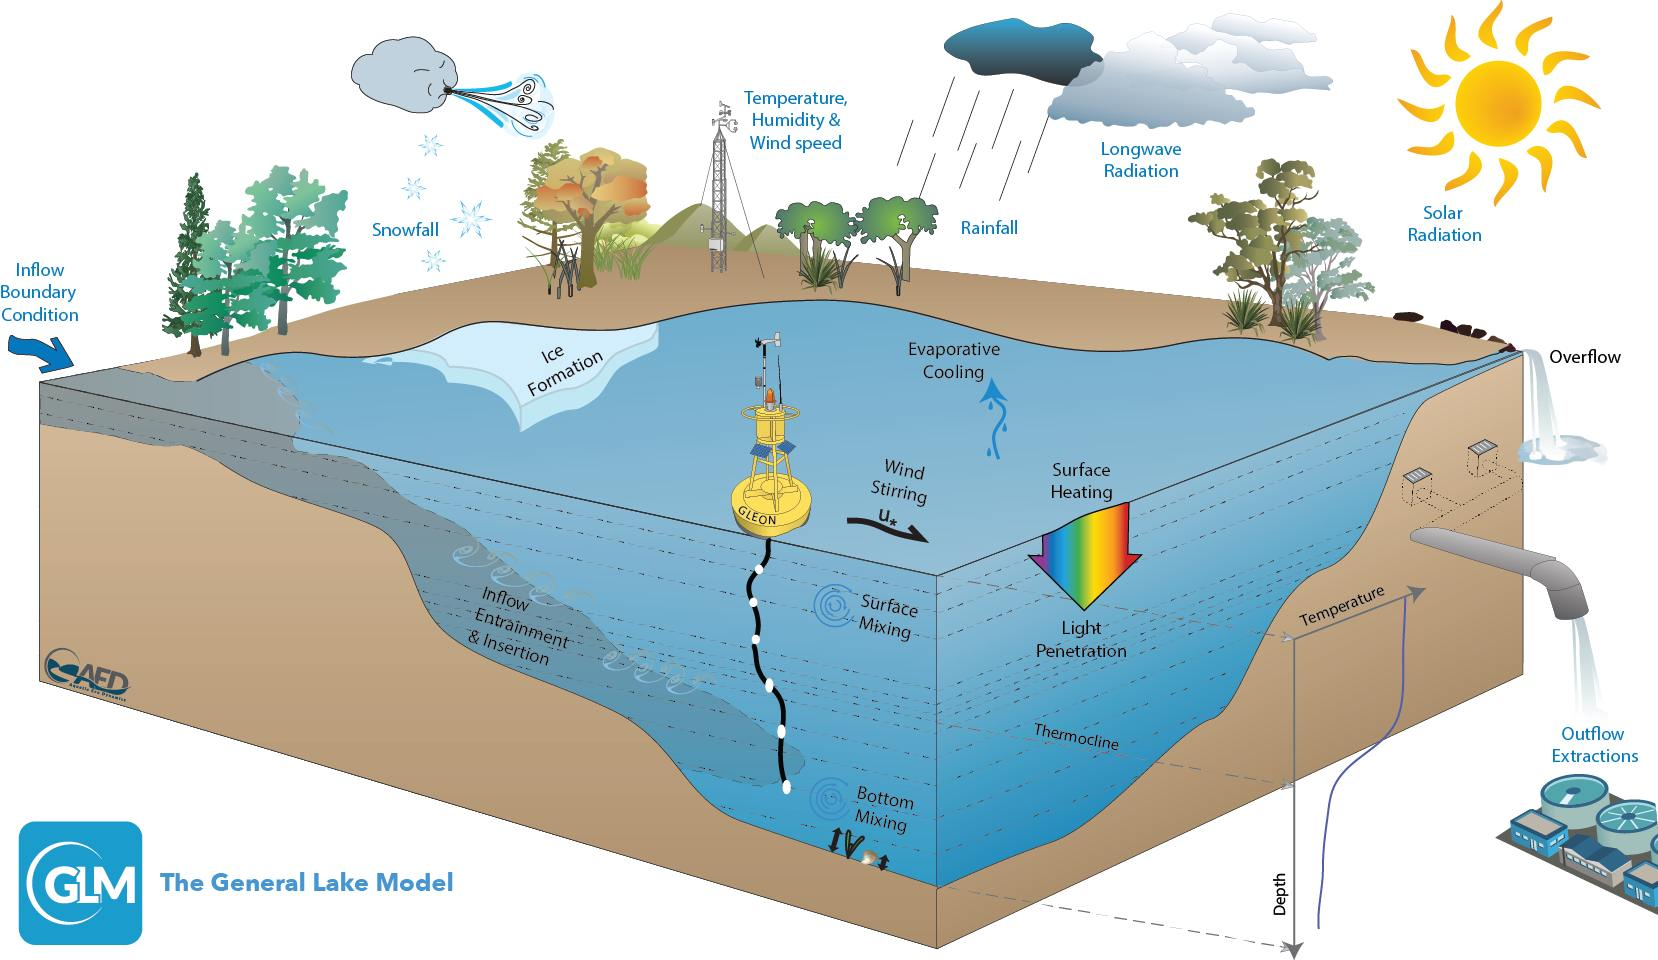

Karpatne et al. combine these to approaches with a neural network to the so called PGNN. PGNNs might provide the following advantages:
* [**Achieving generalization**](https://developers.google.com/machine-learning/crash-course/generalization/video-lecture): Physics models, mostly, do not depend on data and might perform well on unseen data.
* PGNNs could provide a basis to [**Explainable AI**](https://en.wikipedia.org/wiki/Explainable_artificial_intelligence) as they represent physically consistent and interpretable results.

In their paper, Karpatne et al. are modeling the temperature of a given lake. The water temperature controls the growth, survival and reproduction of biological species living in the lake. The temperature therefore is crucial.
The task is to create a model that can predict the lake's temperature as a function of depth and time.

**Feature engineering** was applied by using a model, called the [general lake model (GLM)](https://aed.see.uwa.edu.au/research/models/GLM/), to generate new features and feed them into the NN. This model is a physics model that calculates the lake's temperature as a function of heating due to sin, evaporation etc.

**The physical inconsistency term** takes into account, that denser water sinks. The relationship between water temperature and its density is known, too. The deeper the water, the higher the predicted density should be. If not, it is a physical inconsistency. This can be implementated into the loss function. Furthermore it is possible vary the punishment in dependence of the inconsitency's size.

They implemented several models to compare their results:
* **PHY**: Physical model of the lake (GLM)
* **pureDS**:
* **PGNN_0**: A neural network with feature engineering. The results of this model are fed into a the NN as additional features.
* **PGNN**: A neural network with feature engineering and the modified loss function

and two evaluation measures:
* **RMSE**: Root mean squared error
* **Inconsistency**: Fraction of time-steps where the model makes physically inconsistent predictions.

> 💡 **Results**:\
\begin{array}{|c|c|c|c|}\hline
              & PHY  & pureDS & PHNN0   & PGNN  \\ \hline
RMSE          & 2.57 & 1.77   & 1.21    & 1.16  \\ \hline
Inconsistency &      & 50.2\% & 21.61\% & 2.5\% \\ \hline
\end{array}

### Import and view datasets

In [6]:
# Import datasets
import os
if not os.path.exists("mendota.mat"): 
  !wget https://github.com/arkadaw9/PGNN/blob/master/datasets/mendota.mat
if not os.path.exists("mendota_sampled.mat"): 
  !wget https://github.com/arkadaw9/PGNN/blob/master/datasets/mendota_sampled.mat
if not os.path.exists("mille_lacs.mat"): 
  !wget https://github.com/arkadaw9/PGNN/blob/master/datasets/mille_lacs.mat
if not os.path.exists("mille_lacs_sampled.mat"): 
  !wget https://github.com/arkadaw9/PGNN/blob/master/datasets/mille_lacs_sampled.mat

In [15]:
# View data
import scipy.io as spio
mendota = spio.loadmat("matlab.mat", verify_compressed_data_integrity=False)
print(mendota)

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Mon Jun 27 11:19:32 2022', '__version__': '1.0', '__globals__': [], 'AirTemp': array([[11.23750792],
       [11.23750792],
       [11.23750792],
       ...,
       [ 7.67584333],
       [ 7.67584333],
       [ 7.67584333]]), 'DateTime': array([[array(['1980-04-30'], dtype='<U10')],
       [array(['1980-04-30'], dtype='<U10')],
       [array(['1980-04-30'], dtype='<U10')],
       ...,
       [array(['2015-11-02'], dtype='<U10')],
       [array(['2015-11-02'], dtype='<U10')],
       [array(['2015-11-02'], dtype='<U10')]], dtype=object), 'Depth': array([[ 0. ],
       [ 5. ],
       [10. ],
       ...,
       [23. ],
       [24. ],
       [24.4]]), 'LongWave': array([[336.35958333],
       [336.35958333],
       [336.35958333],
       ...,
       [327.13458333],
       [327.13458333],
       [327.13458333]]), 'Modeled_temp': array([[ 8.55096248],
       [ 8.55096196],
       [ 8.522828  ],
       ...,
       [10.28014374

Sources:
* https://resources.experfy.com/ai-ml/physics-guided-neural-networks-pgnns/
* https://arxiv.org/abs/1710.11431